<a href="https://colab.research.google.com/github/joelcapistrano/mnist-autoencoder/blob/master/MNIST_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Restoration using Autoencoders
Restoring Autoencoder for MNIST.

Input: Input data is an MNIST image corrupted by a white square of at most 25% of the image area

Output: Restored MNIST image w/o the corrupting white square.

In [0]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pylab import rcParams

Load MNIST dataset excluding the labels (images only). Reshape images to (28,28,1) and normalize.

In [0]:
# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Reshape images to (28, 28, 1) and normalize
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

A function that generates corrupted images is created.

An image is corrupted by placing a white square on the original  image. The area of white square follows a uniform distribution over [6.25, 25] percent of the image area, i.e. the dimension of the square should be sampled from S = [7,14] pixels.

Position of white square is randomly chosen. The x- and y-coordinates of the top-left corner are independently sampled from a uniform distribution over [0, 28 - S], where S is the length of the white square's side.

NumPy's random.randit() allows for random selection of an integer from a set of integers that follows a uniform distribution.

In [0]:
x_train_corrupted = x_train.copy()
x_test_corrupted = x_test.copy()

def corrupt(image_set):
  for each_image in image_set:
    each_image = each_image.reshape(28,28)
    # Set white square dimension by randomly selecting an integer from 7 to 14 following a uniform distribution
    n = np.random.randint(7,14)
    # Make white square
    white_square = np.array([1]*n*n).reshape(n,n)
    # Set white square coordinates by randomly selecting a pair of integers from 0 to 28 following a uniform distribution
    x = np.random.randint(0,28-n)
    y = np.random.randint(0,28-n)
    # Add white square to the image
    each_image[x:x+n, y:y+n] = white_square
  return image_set

x_train_corrupted = corrupt(x_train_corrupted)
x_test_corrupted = corrupt(x_test_corrupted)

Ten samples from the original image set (first row) and the corresponding corrupted image set (second row) are shown below.

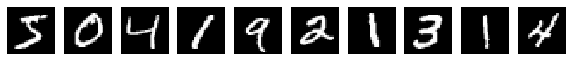

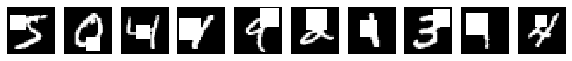

In [4]:
rcParams['figure.figsize'] = 10,10

# Show 10 samples from the original image set
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train[i].reshape(28,28),cmap='gray')
    plt.axis('off')
plt.show()
# Show corresponding corrupted image set
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train_corrupted[i].reshape(28,28),cmap='gray')
    plt.axis('off')
plt.show()

Set network parameters for the Encoder & Decoder models.

Various levels of latent size (dimension) were tested, and `latent_dim = 128` have the best Classifier & SSIM Scores.
This is a step back from `latent_dim = 256` since overfitting became apparent (i.e. Classifier Score started to decrease).

In [0]:
# Set parameters for CNN
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
#latent_dim = 16 # Classifier Score: 93.73, SSIM Score: 89.23
#latent_dim = 32 # Classifier Score: 96.21, SSIM Score: 94.08
#latent_dim = 64 # Classifier Score: 96.89, SSIM Score: 96.55
latent_dim = 128 # Classifier Score: 97.08, SSIM Score: 96.97
#latent_dim = 256 # Classifier Score: 96.91, SSIM Score: 97.20


# Number of CNN layers and filters per layer
layer_filters = [32, 64]

The Encoder model is created and visualized below.

The Encoder model uses a series of Convolutional layers to encode an image into a fixed length vector that represents the image a compact form.

In [6]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# Stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# Shape info for the Decoder model
# Shape is (7, 7, 64) which can be processed by the Decoder back to (28, 28, 1)
shape = K.int_shape(x)

# Generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Encoder model
encoder = Model(inputs, latent, name='encoder')

# Show Encoder model visualization
encoder.summary()




Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 128)               401536    
Total params: 420,352
Trainable params: 420,352
Non-trainable params: 0
_________________________________________________________________


The Decoder model is created and visualized below.

The Decoder model uses Dense and Convolutional layers to convert the latent representation vector back into that same image or another modified image.

In [7]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')

x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)

x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

# Reconstruct the denoised input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

# Instantiate Decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# Show Decoder model visualization
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              404544    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 460,225
Trainable params: 460,225
Non-trainable params: 0
_____________________________________________________

Build the AutoEncoder model by combining the Encoder & Decoder models.

In [8]:
# Instantiate AutoEncoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

# Show AutoEncoder model visualization
autoencoder.summary()


Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 128)               420352    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         460225    
Total params: 880,577
Trainable params: 880,577
Non-trainable params: 0
_________________________________________________________________


Train the AutoEncoder model and store lossess/metrics per epoch in `train_history`.

In [9]:
# train the autoencoder
train_history = autoencoder.fit(x_train_corrupted, x_train,
                validation_data=(x_test_corrupted, x_test),
                epochs=10,
                batch_size=batch_size)





Train on 60000 samples, validate on 10000 samples
Epoch 1/10





60000/60000 [==============================] - 27s 448us/step - loss: 0.0259 - val_loss: 0.0132
Epoch 2/10
60000/60000 [==============================] - 25s 411us/step - loss: 0.0120 - val_loss: 0.0112
Epoch 3/10
60000/60000 [==============================] - 24s 407us/step - loss: 0.0105 - val_loss: 0.0103
Epoch 4/10
60000/60000 [==============================] - 24s 407us/step - loss: 0.0095 - val_loss: 0.0098
Epoch 5/10
60000/60000 [==============================] - 24s 407us/step - loss: 0.0089 - val_loss: 0.0093
Epoch 6/10
60000/60000 [==============================] - 25s 409us/step - loss: 0.0084 - val_loss: 0.0093
Epoch 7/10
60000/60000 [==============================] - 24s 406us/step - loss: 0.0080 - val_loss: 0.0089
Epoch 8/10
60000/60000 [==============================] - 25s 410us/step - loss: 0.0077 - val_loss: 0.0088
Epoch 9/10
60000/60000 [==============================] - 25s 415us/step - loss: 0.007

Visualize losses per epoch during the AutoEncoder model training.

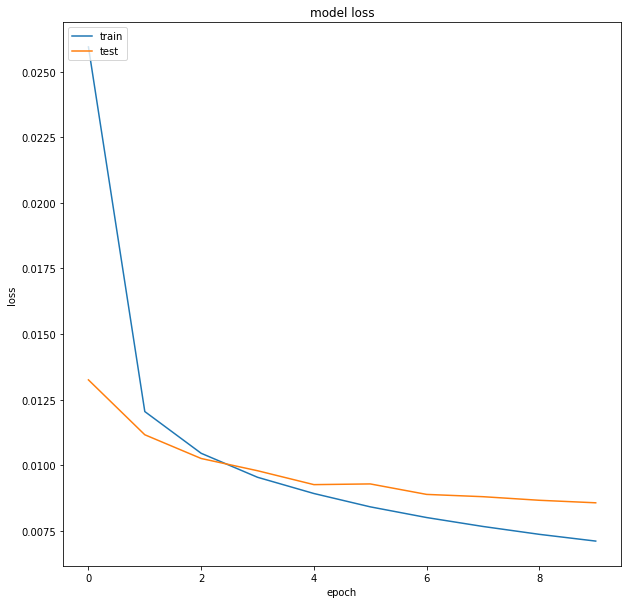

In [10]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Use the AutoEncoder to restore a set of corrupted images (`x_test_corrupted`).

Ten samples of the corrupted images (first row), restored images (second row), and the original image (third row) are shown below.

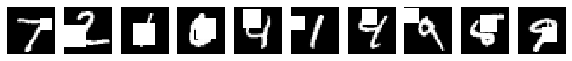

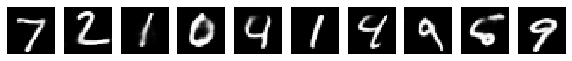

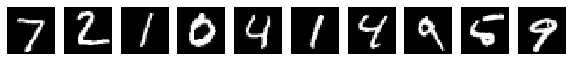

In [11]:
x_decoded = autoencoder.predict(x_test_corrupted)

rcParams['figure.figsize'] = 10,10

# Show corrupted images
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_test_corrupted[i].reshape(28,28),cmap='gray')
    plt.axis('off')
plt.show()
# Show restored images
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_decoded[i].reshape(28,28),cmap='gray')
    plt.axis('off')
plt.show()
# Show original images
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_test[i].reshape(28,28),cmap='gray')
    plt.axis('off')
plt.show()

Get Classifier & SSIM scores and compare against the baseline (78.36 & 75.00, respectively).

In [0]:
# Clone Git Repo
! git clone https://github.com/baudm/ee298z.git

In [14]:
# Import
from ee298z.hw2.benchmark_keras import test_model

# Load MNIST dataset including the labels
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize
x_test = x_test.astype(K.floatx()) / 255.

# Get Classifier 
test_model(autoencoder, x_test, y_test, batch_size=100)

Classifier score: 97.08
SSIM score: 96.97


Compared to the baseline Classifier & SSIM Scores, the autoencoder was able to achieve higher scores (97.08 & 96.97, respectively).

Adjusting/tuning the latent size led to a significant increase in the autoencoder model's Classifier & SSIM Scores. If the latent value is too small, there won’t be enough data for reconstruction. If the value is too large, overfitting can occur. This makes the latent value a crucial hyperparameter for autoencoder models.

